In [1]:
!conda install -c anaconda beautifulsoup4 --yes
!conda install -c conda-forge folium=0.11.0 --yes
!conda install -c conda-forge geopy --yes
!conda install -c anaconda lxml --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.1       |           py36_0         168 KB  anaconda
    ca-certificates-2020.6.24  |                0         133 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    soupsieve-2.0.1            |             py_0          33 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     anaconda/linux-64::beautifulsoup4-4.9.1-py36_0
  soupsieve          anaconda/noarch::soupsieve-2.0.1-py_0

The following packag

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import seaborn as sns
import requests

# for web scraping the data form webpages
from bs4 import BeautifulSoup

# convert an address into latitude and longitude values
import geopy
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# map rendering library
import folium
from folium import plugins
from folium import Map
from folium.plugins import HeatMap

# Library for K-Means Clustering
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 


In [4]:
# Scraping the Wikipedia page for London areas.
url = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
webpg = requests.get(url).text

parpg = BeautifulSoup(webpg, "lxml")
print(parpg.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of areas of London - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"f0fa87c3-a72a-452a-a8bd-44350109b6d1","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_areas_of_London","wgTitle":"List of areas of London","wgCurRevisionId":963608799,"wgRevisionId":963608799,"wgArticleId":11915713,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Use dmy dates from August 2015","Use Br

In [5]:
# Extracting required table from the webpage
nghd_table = parpg.find('table', {'class':'wikitable sortable'})


#Converting the extracted-table into into Pandas Dataframe
A = []
B = []
C = []
D = []

for row in nghd_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==6:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        
        
i = j = k = l = 0
for a in A:
    tempA = a.replace('\n','')
    A[i] = tempA
    i = i+1

for b in B:
    tempB = b.replace('\n','')
    B[j] = tempB
    j = j+1
    
for c in C:
    tempC = c.replace('\n','')
    C[k] = tempC
    k = k+1
    
for d in D:
    tempD = d.replace('\n','')
    D[l] = tempD
    l = l+1
    
    
df=pd.DataFrame(A,columns=['Neighborhood'])
df['London borough']=B
df['Post town']=C
df['Postcode district']=D
df.head(20)

,Neighborhood,London borough,Post town,Postcode district
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
5,Aldborough Hatch,Redbridge,ILFORD,IG2
6,Aldgate,City,LONDON,EC3
7,Aldwych,Westminster,LONDON,WC2
8,Alperton,Brent,WEMBLEY,HA0
9,Anerley,Bromley,LONDON,SE20


In [6]:
#Removing the Paranthesis text written in the 'Neighborhood' column
import re

p = 0

for text in df['Neighborhood']:
    df['Neighborhood'][p] = re.sub(r" ?\([^)]+\)", "", text)
    p = p+1   

In [7]:
#Adding columns for Latitude and Longitude of the Neighborhoods
df['Neighborhood Latitude'] = None
df['Neighborhood Longitude'] = None

In [8]:
#Finding the coordinates of Neighborhood using 'NOMINATIM' and populating the above created colums of Neighborhood Lat. & Long.

o = 0
for address in df['Neighborhood']:
    address = address+', UK'
    geolocator = Nominatim(user_agent="London_explorer")
    location = geolocator.geocode(address)
    if (location != None):
        df['Neighborhood Latitude'][o] = location.latitude
        df['Neighborhood Longitude'][o] = location.longitude
    o = o+1


#One entry was not provided by 'NOMINATIM', so populating it manually
df['Neighborhood Latitude'][5] = 51.5855
df['Neighborhood Longitude'][5] = 0.0988

df.head(20)

,Neighborhood,London borough,Post town,Postcode district,Neighborhood Latitude,Neighborhood Longitude
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,51.4876,0.11405
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",51.5081,-0.273261
2,Addington,Croydon,CROYDON,CR0,51.3586,-0.0316347
3,Addiscombe,Croydon,CROYDON,CR0,51.3797,-0.0742821
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",51.4354,0.125965
5,Aldborough Hatch,Redbridge,ILFORD,IG2,51.5855,0.0988
6,Aldgate,City,LONDON,EC3,51.5142,-0.0757186
7,Aldwych,Westminster,LONDON,WC2,52.9286,-1.52057
8,Alperton,Brent,WEMBLEY,HA0,51.5408,-0.300096
9,Anerley,Bromley,LONDON,SE20,51.4076,-0.0619394


In [9]:
# Saving the Dataframe for future use to save time. 
# df.to_csv('df.csv')

In [10]:
#Defining the Foursquare API credentials
CLIENT_ID = 'R5DTKSBGDOVZBKBZVLLS25VE4YJMSSJEN1OO544ZTUTEWAEP' 
CLIENT_SECRET = 'XLJGXBZXBQIWQYB3EY3FTGAYHFTYABYCMCKCCBBYDW1ZKQK3' 
VERSION = '20200709' 
radius = 500
LIMIT = 200

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R5DTKSBGDOVZBKBZVLLS25VE4YJMSSJEN1OO544ZTUTEWAEP
CLIENT_SECRET:XLJGXBZXBQIWQYB3EY3FTGAYHFTYABYCMCKCCBBYDW1ZKQK3


In [11]:
#Defining the Function for getting the nearby venues of a given coordinates/Neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    v = 1
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(v, name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        v = v+1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
#Obtaining venues for London-Neighborhood
london_nghd_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Neighborhood Latitude'],
                                   longitudes=df['Neighborhood Longitude']
                                  )

In [13]:
# Saving the dataframe as csv file for future use without repeating the resources.
# london_nghd_venues.to_csv('london_nghd_venues.csv')

In [14]:
london_nghd_venues = pd.read_csv('london_nghd_venues.csv')
london_nghd_venues.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [15]:
print(london_nghd_venues.shape)
london_nghd_venues.head()

(11713, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.487621,0.114050,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.487621,0.114050,Bostal Gardens,51.486670,0.110462,Playground
2,Abbey Wood,51.487621,0.114050,Abbey Wood Caravan Club,51.485502,0.120014,Campground
3,Acton,51.508140,-0.273261,London Star Hotel,51.509624,-0.272456,Hotel
4,Acton,51.508140,-0.273261,The Aeronaut,51.508376,-0.275216,Pub


In [16]:
london_nghd_venues['Venue Type'] = np.nan

In [17]:
print(london_nghd_venues.shape)
london_nghd_venues.head()

(11713, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Type
0,Abbey Wood,51.487621,0.114050,Co-op Food,51.487650,0.113490,Grocery Store,NaN
1,Abbey Wood,51.487621,0.114050,Bostal Gardens,51.486670,0.110462,Playground,NaN
2,Abbey Wood,51.487621,0.114050,Abbey Wood Caravan Club,51.485502,0.120014,Campground,NaN
3,Acton,51.508140,-0.273261,London Star Hotel,51.509624,-0.272456,Hotel,NaN
4,Acton,51.508140,-0.273261,The Aeronaut,51.508376,-0.275216,Pub,NaN


In [18]:
print('There are {} unique venue-categories.'.format(len(london_nghd_venues['Venue Category'].unique())))

There are 410 unique venue-categories.


In [19]:
# Reading a dataframe where Venue-Categories are further divided into VENUE-TYPE
q = pd.read_csv('q.csv')
q = q[q['Venue Category'].isin(list(london_nghd_venues['Venue Category'].unique()))]
q.reset_index(inplace = True)
q.drop('index', 1, inplace = True)

print(q.shape)
q.head()

(410, 3)


,Venue Category,No.,Venue Type
0,Pub,829,Pubs_bars
1,Coffee Shop,759,Cafe_fastfood
2,Café,636,Cafe_fastfood
3,Grocery Store,463,Grocery_daily
4,Hotel,387,Hotels_boarding


In [20]:
# Populating Venue Types for various venue categories in London Neighborhoods
i = 0
for vc1 in london_nghd_venues['Venue Category']:
    j = 0
    for vc2 in q['Venue Category']:
        if (vc1 == vc2):
            london_nghd_venues['Venue Type'][i] = q['Venue Type'][j]
            j = j+1
            break
        else:
            j = j+1
    
    i = i+1

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
london_nghd_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Type
0,Abbey Wood,51.487621,0.114050,Co-op Food,51.487650,0.113490,Grocery Store,Grocery_daily
1,Abbey Wood,51.487621,0.114050,Bostal Gardens,51.486670,0.110462,Playground,Sports_fitness
2,Abbey Wood,51.487621,0.114050,Abbey Wood Caravan Club,51.485502,0.120014,Campground,Sports_fitness
3,Acton,51.508140,-0.273261,London Star Hotel,51.509624,-0.272456,Hotel,Hotels_boarding
4,Acton,51.508140,-0.273261,The Aeronaut,51.508376,-0.275216,Pub,Pubs_bars


In [22]:
london_nghd_venues.isnull().sum()

Neighborhood                0
Neighborhood Latitude       0
Neighborhood Longitude      0
Venue                       0
Venue Latitude              0
Venue Longitude             0
Venue Category              0
Venue Type                113
dtype: int64

In [23]:
london_nghd_venues.dropna(inplace = True)
london_nghd_venues.reset_index(inplace=True)

In [24]:
london_nghd_venues.isnull().sum()

index                     0
Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
Venue Type                0
dtype: int64

In [25]:
print('There are {} unique venue-types.'.format(len(london_nghd_venues['Venue Type'].unique())))

There are 14 unique venue-types.


### Preparing the Data For K-Means Clustering

In [26]:
imp = london_nghd_venues['Venue Type'].value_counts()
imp = pd.DataFrame(imp)
imp.reset_index(inplace=True)
imp.columns = ['Venue Type', 'Count']
imp['Weight'] =''

In [27]:
print(imp.shape)
imp.head(15)

(14, 3)


,Venue Type,Count,Weight
0,Cafe_fastfood,3016,
1,Restaurants,2418,
2,Pubs_bars,1453,
3,Shopping_retail,1154,
4,Grocery_daily,882,
5,Entertainment_recreation,702,
6,Sports_fitness,572,
7,Hotels_boarding,436,
8,Transportation,432,
9,Tourists_landmarks,315,


In [28]:
t = 0
for vtype in imp['Venue Type']:
    imp['Weight'][t] = 1/((imp['Count'][t]/(imp['Count'].sum()))*1000)
    t = t+1

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
imp['Weight'] = imp['Weight'].astype(float)
imp = imp.sort_values('Venue Type')
imp.reset_index(inplace=True)
imp.drop('index', 1, inplace=True)
imp.head(15)

,Venue Type,Count,Weight
0,Business_office,25,0.464000
1,Cafe_fastfood,3016,0.003846
2,Education_school,5,2.320000
3,Entertainment_recreation,702,0.016524
4,Grocery_daily,882,0.013152
5,Hotels_boarding,436,0.026606
6,Personal_care,45,0.257778
7,Pharmacy,145,0.080000
8,Pubs_bars,1453,0.007983
9,Restaurants,2418,0.004797


In [30]:
# one hot encoding
london_nghd_onehot = pd.get_dummies(london_nghd_venues[['Venue Type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
temp = london_nghd_venues['Neighborhood'].tolist()
# london_nghd_onehot.drop(['Neighborhood'], axis = 1, inplace=True)
london_nghd_onehot.insert(loc=0, column='Neighborhood', value=temp)

print(london_nghd_onehot.shape)
london_nghd_onehot.head()

(11600, 15)


,Neighborhood,Business_office,Cafe_fastfood,Education_school,Entertainment_recreation,Grocery_daily,Hotels_boarding,Personal_care,Pharmacy,Pubs_bars,Restaurants,Shopping_retail,Sports_fitness,Tourists_landmarks,Transportation
0,Abbey Wood,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Acton,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Acton,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [31]:
london_nghd_grouped = london_nghd_onehot.groupby('Neighborhood').sum().reset_index()
print(london_nghd_grouped.shape)
london_nghd_grouped.head()

(510, 15)


,Neighborhood,Business_office,Cafe_fastfood,Education_school,Entertainment_recreation,Grocery_daily,Hotels_boarding,Personal_care,Pharmacy,Pubs_bars,Restaurants,Shopping_retail,Sports_fitness,Tourists_landmarks,Transportation
0,Abbey Wood,0,0,0,0,1,0,0,0,0,0,0,2,0,0
1,Acton,0,4,0,0,1,1,0,0,5,3,1,3,0,0
2,Addington,0,0,0,1,0,0,0,0,0,1,0,0,0,2
3,Addiscombe,0,3,0,2,2,0,0,0,0,2,0,0,0,0
4,Albany Park,0,0,0,0,1,0,0,0,1,1,0,0,0,1


In [32]:
london_nghd_clstrng = london_nghd_grouped.copy()
print(london_nghd_clstrng.shape)

(510, 15)


In [33]:
z = 0
for ventype in imp['Venue Type']:
    london_nghd_clstrng[ventype] = london_nghd_clstrng[ventype] * imp['Weight'][z]
    z = z+1

In [34]:
print(london_nghd_clstrng.shape)
london_nghd_clstrng.head()

(510, 15)


,Neighborhood,Business_office,Cafe_fastfood,Education_school,Entertainment_recreation,Grocery_daily,Hotels_boarding,Personal_care,Pharmacy,Pubs_bars,Restaurants,Shopping_retail,Sports_fitness,Tourists_landmarks,Transportation
0,Abbey Wood,0.0,0.000000,0.0,0.000000,0.013152,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.040559,0.0,0.000000
1,Acton,0.0,0.015385,0.0,0.000000,0.013152,0.026606,0.0,0.0,0.039917,0.014392,0.010052,0.060839,0.0,0.000000
2,Addington,0.0,0.000000,0.0,0.016524,0.000000,0.000000,0.0,0.0,0.000000,0.004797,0.000000,0.000000,0.0,0.053704
3,Addiscombe,0.0,0.011538,0.0,0.033048,0.026304,0.000000,0.0,0.0,0.000000,0.009595,0.000000,0.000000,0.0,0.000000
4,Albany Park,0.0,0.000000,0.0,0.000000,0.013152,0.000000,0.0,0.0,0.007983,0.004797,0.000000,0.000000,0.0,0.026852


In [35]:
#SCALING FEATURES
tt1 = london_nghd_clstrng.drop('Neighborhood', 1)

from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler = MinMaxScaler()

# scaling
tt2 = scaler.fit_transform(tt1)

# putting back the column names
tt2 = pd.DataFrame(tt2, columns = tt1.columns)

temp = london_nghd_clstrng['Neighborhood'].tolist()
tt2.insert(loc=0, column='Neighborhood', value=temp)


london_nghd_clstrng = tt2
print(london_nghd_clstrng.shape)
london_nghd_clstrng.head()

(510, 15)


,Neighborhood,Business_office,Cafe_fastfood,Education_school,Entertainment_recreation,Grocery_daily,Hotels_boarding,Personal_care,Pharmacy,Pubs_bars,Restaurants,Shopping_retail,Sports_fitness,Tourists_landmarks,Transportation
0,Abbey Wood,0.0,0.000,0.0,0.000000,0.125,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.250,0.0,0.000
1,Acton,0.0,0.100,0.0,0.000000,0.125,0.045455,0.0,0.0,0.217391,0.081081,0.037037,0.375,0.0,0.000
2,Addington,0.0,0.000,0.0,0.066667,0.000,0.000000,0.0,0.0,0.000000,0.027027,0.000000,0.000,0.0,0.250
3,Addiscombe,0.0,0.075,0.0,0.133333,0.250,0.000000,0.0,0.0,0.000000,0.054054,0.000000,0.000,0.0,0.000
4,Albany Park,0.0,0.000,0.0,0.000000,0.125,0.000000,0.0,0.0,0.043478,0.027027,0.000000,0.000,0.0,0.125


In [36]:
london_nghd_clstrng = london_nghd_clstrng.drop('Neighborhood', 1)
print(london_nghd_clstrng.shape)
london_nghd_clstrng.head()

(510, 14)


,Business_office,Cafe_fastfood,Education_school,Entertainment_recreation,Grocery_daily,Hotels_boarding,Personal_care,Pharmacy,Pubs_bars,Restaurants,Shopping_retail,Sports_fitness,Tourists_landmarks,Transportation
0,0.0,0.000,0.0,0.000000,0.125,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.250,0.0,0.000
1,0.0,0.100,0.0,0.000000,0.125,0.045455,0.0,0.0,0.217391,0.081081,0.037037,0.375,0.0,0.000
2,0.0,0.000,0.0,0.066667,0.000,0.000000,0.0,0.0,0.000000,0.027027,0.000000,0.000,0.0,0.250
3,0.0,0.075,0.0,0.133333,0.250,0.000000,0.0,0.0,0.000000,0.054054,0.000000,0.000,0.0,0.000
4,0.0,0.000,0.0,0.000000,0.125,0.000000,0.0,0.0,0.043478,0.027027,0.000000,0.000,0.0,0.125


# Clustering the prepared data using K-Means:

In [37]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,50) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(london_nghd_clstrng) 
    kmeanModel.fit(london_nghd_clstrng)     
      
    distortions.append(sum(np.min(cdist(london_nghd_clstrng, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / london_nghd_clstrng.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(london_nghd_clstrng, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / london_nghd_clstrng.shape[0] 
    mapping2[k] = kmeanModel.inertia_

### Elbow method for selecting number of clusters:

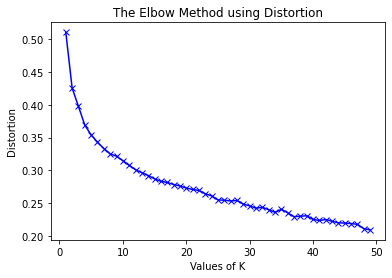

In [38]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

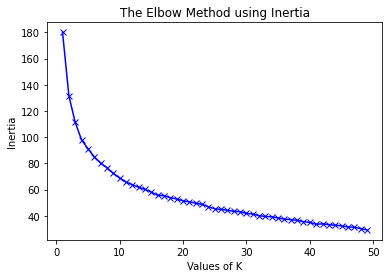

In [39]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [40]:
# setting number of clusters from above elbow method
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_nghd_clstrng)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 1, 1, 1, 1, 3, 1, 1, 9], dtype=int32)

In [41]:
# add clustering labels
# london_nghd_grouped.drop(['Cluster Labels'], axis=1, inplace=True)
london_nghd_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
london_nghd_grouped.shape

(510, 16)

In [42]:
london_nghd_grouped['Latitude'] = None
london_nghd_grouped['Longitude'] = None

In [43]:
london_nghd_grouped.isnull().sum()

Cluster Labels                0
Neighborhood                  0
Business_office               0
Cafe_fastfood                 0
Education_school              0
Entertainment_recreation      0
Grocery_daily                 0
Hotels_boarding               0
Personal_care                 0
Pharmacy                      0
Pubs_bars                     0
Restaurants                   0
Shopping_retail               0
Sports_fitness                0
Tourists_landmarks            0
Transportation                0
Latitude                    510
Longitude                   510
dtype: int64

In [44]:
p = 0

for neighborhood in london_nghd_grouped['Neighborhood']:
    q = 0
    for n_ref in london_nghd_venues['Neighborhood']:
        if(neighborhood == n_ref):
            london_nghd_grouped['Latitude'][p] = london_nghd_venues['Neighborhood Latitude'][q]
            london_nghd_grouped['Longitude'][p] = london_nghd_venues['Neighborhood Longitude'][q]
            q = q + 1
        else:
            q = q + 1
            
    p = p + 1

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
london_nghd_grouped.isnull().sum()

Cluster Labels              0
Neighborhood                0
Business_office             0
Cafe_fastfood               0
Education_school            0
Entertainment_recreation    0
Grocery_daily               0
Hotels_boarding             0
Personal_care               0
Pharmacy                    0
Pubs_bars                   0
Restaurants                 0
Shopping_retail             0
Sports_fitness              0
Tourists_landmarks          0
Transportation              0
Latitude                    0
Longitude                   0
dtype: int64

In [46]:
print(london_nghd_grouped.shape)
london_nghd_grouped.head()

(510, 18)


,Cluster Labels,Neighborhood,Business_office,Cafe_fastfood,Education_school,Entertainment_recreation,Grocery_daily,Hotels_boarding,Personal_care,Pharmacy,Pubs_bars,Restaurants,Shopping_retail,Sports_fitness,Tourists_landmarks,Transportation,Latitude,Longitude
0,1,Abbey Wood,0,0,0,0,1,0,0,0,0,0,0,2,0,0,51.4876,0.11405
1,4,Acton,0,4,0,0,1,1,0,0,5,3,1,3,0,0,51.5081,-0.273261
2,1,Addington,0,0,0,1,0,0,0,0,0,1,0,0,0,2,51.3586,-0.0316347
3,1,Addiscombe,0,3,0,2,2,0,0,0,0,2,0,0,0,0,51.3797,-0.0742821
4,1,Albany Park,0,0,0,0,1,0,0,0,1,1,0,0,0,1,51.4354,0.125965


In [47]:
aa = london_nghd_grouped.copy()
aa.drop('Neighborhood', 1, inplace = True)
aa.rename(columns = {'Cluster Labels':'Venue Type'}, inplace = True)
aa = aa.groupby('Venue Type').sum().reset_index()
aa.set_index('Venue Type',inplace=True)
aa = aa.transpose()
aa = aa.astype(int)
aa.rename(columns = {0:'C1', 1:'C2', 2:'C3', 3:'C4', 4:'C5', 
                    5:'C6', 6:'C7', 7:'C8', 8:'C9', 9:'C10'}, inplace = True) 

aa['SUM'] = aa.sum(axis=1)
aa.loc['TOTAL'] = aa.sum()


print(aa.shape)
aa.head(15)

(15, 11)


Venue Type,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,SUM
Business_office,0,0,0,5,0,0,0,1,19,0,25
Cafe_fastfood,115,375,420,108,302,302,774,89,91,440,3016
Education_school,0,0,0,0,0,0,0,5,0,0,5
Entertainment_recreation,30,144,67,18,87,40,208,16,18,74,702
Grocery_daily,47,177,117,17,48,107,67,9,30,263,882
Hotels_boarding,18,60,53,37,41,24,129,18,16,40,436
Personal_care,4,8,4,1,6,2,12,3,0,5,45
Pharmacy,4,5,44,5,3,59,6,3,4,12,145
Pubs_bars,50,250,170,64,142,123,335,41,55,223,1453
Restaurants,86,320,349,102,240,250,579,70,75,347,2418


### Visualizing distribution of data among clusters for cluster-profiling:

In [48]:
# using SEABORN for color coded visualization of distribution: 
cm1 = sns.light_palette("red", as_cmap=True)

# Percentage share of each Venue-Type among different clusters (ROW-WISE):
rr = aa.copy()
rr = rr.astype(float)

for i in range(14):
    for j in range(10):
        a = (rr.iat[i, j]/rr.iat[i, 10])*100
        rr.iat[i, j] = a
rr.drop('SUM', 1, inplace = True)
rr.drop('TOTAL', 0, inplace = True)


# Percentage share of different Venue-Types within each Cluster (COLUMN-WISE):
cc = aa.copy()
cc = cc.astype(float)

for j in range(10):
    for i in range(14):
        a = (cc.iat[i, j]/cc.iat[14, j])*100
        cc.iat[i, j] = a
cc.drop('SUM', 1, inplace = True)
cc.drop('TOTAL', 0, inplace = True)


printmd('**Percentage Distribution of *Venue-Types* across Clusters (Row-wise):**')
display(rr.style.background_gradient(cmap='GnBu',  low=0, high=0, axis=1, subset=None))
print('\n')
printmd('**===========================================================================**')
print('\n')
printmd('**Percentage Distribution of Venue-Types within each *Cluster* (Column-wise):**')
display(cc.style.background_gradient(cmap='GnBu',  low=0, high=0, axis=0, subset=None))

**Percentage Distribution of *Venue-Types* across Clusters (Row-wise):**

Venue Type,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
Business_office,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,4.000000,76.000000,0.000000
Cafe_fastfood,3.812997,12.433687,13.925729,3.580902,10.013263,10.013263,25.663130,2.950928,3.017241,14.588859
Education_school,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
Entertainment_recreation,4.273504,20.512821,9.544160,2.564103,12.393162,5.698006,29.629630,2.279202,2.564103,10.541311
Grocery_daily,5.328798,20.068027,13.265306,1.927438,5.442177,12.131519,7.596372,1.020408,3.401361,29.818594
Hotels_boarding,4.128440,13.761468,12.155963,8.486239,9.403670,5.504587,29.587156,4.128440,3.669725,9.174312
Personal_care,8.888889,17.777778,8.888889,2.222222,13.333333,4.444444,26.666667,6.666667,0.000000,11.111111
Pharmacy,2.758621,3.448276,30.344828,3.448276,2.068966,40.689655,4.137931,2.068966,2.758621,8.275862
Pubs_bars,3.441156,17.205781,11.699931,4.404680,9.772884,8.465244,23.055747,2.821748,3.785272,15.347557
Restaurants,3.556658,13.234078,14.433416,4.218362,9.925558,10.339123,23.945409,2.894955,3.101737,14.350703


**===========================================================================**

**Percentage Distribution of Venue-Types within each *Cluster* (Column-wise):**

Venue Type,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
Business_office,0.000000,0.000000,0.000000,1.176471,0.000000,0.000000,0.000000,0.310559,4.668305,0.000000
Cafe_fastfood,19.930676,21.601382,25.830258,25.411765,26.491228,27.404719,29.318182,27.639752,22.358722,27.076923
Education_school,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.552795,0.000000,0.000000
Entertainment_recreation,5.199307,8.294931,4.120541,4.235294,7.631579,3.629764,7.878788,4.968944,4.422604,4.553846
Grocery_daily,8.145581,10.195853,7.195572,4.000000,4.210526,9.709619,2.537879,2.795031,7.371007,16.184615
Hotels_boarding,3.119584,3.456221,3.259533,8.705882,3.596491,2.177858,4.886364,5.590062,3.931204,2.461538
Personal_care,0.693241,0.460829,0.246002,0.235294,0.526316,0.181488,0.454545,0.931677,0.000000,0.307692
Pharmacy,0.693241,0.288018,2.706027,1.176471,0.263158,5.353902,0.227273,0.931677,0.982801,0.738462
Pubs_bars,8.665511,14.400922,10.455105,15.058824,12.456140,11.161525,12.689394,12.732919,13.513514,13.723077
Restaurants,14.904679,18.433180,21.463715,24.000000,21.052632,22.686025,21.931818,21.739130,18.427518,21.353846


In [49]:
for n in range(10):
    ln_nghd_cluster = london_nghd_grouped.loc[london_nghd_grouped['Cluster Labels'] == n,
                                london_nghd_grouped.columns[[1] + list(range(2, london_nghd_grouped.shape[1]))]]
    print('No. of Neighborhoods in Cluster ' + str((n+1)) + ': ', ln_nghd_cluster.shape[0])

No. of Neighborhoods in Cluster 1:  31
No. of Neighborhoods in Cluster 2:  254
No. of Neighborhoods in Cluster 3:  24
No. of Neighborhoods in Cluster 4:  5
No. of Neighborhoods in Cluster 5:  32
No. of Neighborhoods in Cluster 6:  39
No. of Neighborhoods in Cluster 7:  35
No. of Neighborhoods in Cluster 8:  5
No. of Neighborhoods in Cluster 9:  19
No. of Neighborhoods in Cluster 10:  66


In [50]:
# Defining Latitude and Longitude of London, UK using Nominatim
geolocator = Nominatim(user_agent="london_nghd_explorer")
location = geolocator.geocode("London, UK")
latitude = location.latitude
longitude = location.longitude

# Creating map
map_clusters = folium.Map(location=[latitude, longitude], tiles='Stamen Toner', min_zoom=9, max_zoom=12, zoom_start=11)

# Settin color-scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_nghd_grouped['Latitude'], 
                                  london_nghd_grouped['Longitude'], 
                                  london_nghd_grouped['Neighborhood'], 
                                  london_nghd_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster Label ' + str(cluster) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0).add_to(map_clusters)


map_clusters

# Data For London Borough Profiles

In [51]:
borough_profile = pd.read_csv('london-borough-profiles.csv', encoding = 'ISO-8859-1')
display(borough_profile.head())
display(borough_profile.tail(6))

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015","Proportion_of_population_aged_65_and_over,_2015",Net_internal_migration_(2015),Net_international_migration_(2015),Net_natural_change_(2015),%_of_resident_population_born_abroad_(2015),Largest_migrant_population_by_country_of_birth_(2011),%_of_largest_migrant_population_(2011),Second_largest_migrant_population_by_country_of_birth_(2011),%_of_second_largest_migrant_population_(2011),Third_largest_migrant_population_by_country_of_birth_(2011),%_of_third_largest_migrant_population_(2011),%_of_population_from_BAME_groups_(2016),%_people_aged_3+_whose_main_language_is_not_English_(2011_Census),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)","New_migrant_(NINo)_rates,_(2015/16)",Largest_migrant_population_arrived_during_2015/16,Second_largest_migrant_population_arrived_during_2015/16,Third_largest_migrant_population_arrived_during_2015/16,Employment_rate_(%)_(2015),Male_employment_rate_(2015),Female_employment_rate_(2015),Unemployment_rate_(2015),Youth_Unemployment_(claimant)_rate_18-24_(Dec-15),Proportion_of_16-18_year_olds_who_are_NEET_(%)_(2014),Proportion_of_the_working-age_population_who_claim_out-of-work_benefits_(%)_(May-2016),%_working-age_with_a_disability_(2015),Proportion_of_working_age_people_with_no_qualifications_(%)_2015,Proportion_of_working_age_with_degree_or_equivalent_and_above_(%)_2015,"Gross_Annual_Pay,_(2016)",Gross_Annual_Pay_-_Male_(2016),Gross_Annual_Pay_-_Female_(2016),Modelled_Household_median_income_estimates_2012/13,%_adults_that_volunteered_in_past_12_months_(2010/11_to_2012/13),Number_of_jobs_by_workplace_(2014),%_of_employment_that_is_in_public_sector_(2014),"Jobs_Density,_2015","Number_of_active_businesses,_2015",Two-year_business_survival_rates_(started_in_2013),Crime_rates_per_thousand_population_2014/15,Fires_per_thousand_population_(2014),Ambulance_incidents_per_hundred_population_(2014),"Median_House_Price,_2015","Average_Band_D_Council_Tax_charge_(£),_2015/16",New_Homes_(net)_2015/16_(provisional),"Homes_Owned_outright,_(2014)_%","Being_bought_with_mortgage_or_loan,_(2014)_%","Rented_from_Local_Authority_or_Housing_Association,_(2014)_%","Rented_from_Private_landlord,_(2014)_%","%_of_area_that_is_Greenspace,_2005",Total_carbon_emissions_(2014),"Household_Waste_Recycling_Rate,_2014/15","Number_of_cars,_(2011_Census)","Number_of_cars_per_household,_(2011_Census)","%_of_adults_who_cycle_at_least_once_per_month,_2014/15","Average_Public_Transport_Accessibility_score,_2014","Achievement_of_5_or_more_A*-_C_grades_at_GCSE_or_equivalent_including_English_and_Maths,_2013/14",Rates_of_Children_Looked_After_(2016),%_of_pupils_whose_first_language_is_not_English_(2015),%_children_living_in_out-of-work_households_(2015),"Male_life_expectancy,_(2012-14)","Female_life_expectancy,_(2012-14)",Teenage_conception_rate_(2014),Life_satisfaction_score_2011-14_(out_of_10),Worthwhileness_score_2011-14_(out_of_10),Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800,5326,290,30.3,43.2,11.4,73.1,15.5,-7,665,30,.,United States,2.8,France,2,Australia,1.9,27.5,17.1,975,152.2,India,France,United States,64.6,.,.,.,1.6,.,3.4,.,.,.,.,.,.,"£63,620",.,500400,3.4,84.3,26130,64.3,.,12.3,.,799999,931.2,80,.,.,.,.,4.8,1036,34.4,1692,0.4,16.9,7.9,78.6,101,.,7.9,.,.,.,6.6,7.1,6.0,5.6,NaN,2.6,129,.,.,.,.,.
1,E09000002,Barking and Dagenham,Outer London,209000,

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015","Proportion_of_population_aged_65_and_over,_2015",Net_internal_migration_(2015),Net_international_migration_(2015),Net_natural_change_(2015),%_of_resident_population_born_abroad_(2015),Largest_migrant_population_by_country_of_birth_(2011),%_of_largest_migrant_population_(2011),Second_largest_migrant_population_by_country_of_birth_(2011),%_of_second_largest_migrant_population_(2011),Third_largest_migrant_population_by_country_of_birth_(2011),%_of_third_largest_migrant_population_(2011),%_of_population_from_BAME_groups_(2016),%_people_aged_3+_whose_main_language_is_not_English_(2011_Census),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)","New_migrant_(NINo)_rates,_(2015/16)",Largest_migrant_population_arrived_during_2015/16,Second_largest_migrant_population_arrived_during_2015/16,Third_largest_migrant_population_arrived_during_2015/16,Employment_rate_(%)_(2015),Male_employment_rate_(2015),Female_employment_rate_(2015),Unemployment_rate_(2015),Youth_Unemployment_(claimant)_rate_18-24_(Dec-15),Proportion_of_16-18_year_olds_who_are_NEET_(%)_(2014),Proportion_of_the_working-age_population_who_claim_out-of-work_benefits_(%)_(May-2016),%_working-age_with_a_disability_(2015),Proportion_of_working_age_people_with_no_qualifications_(%)_2015,Proportion_of_working_age_with_degree_or_equivalent_and_above_(%)_2015,"Gross_Annual_Pay,_(2016)",Gross_Annual_Pay_-_Male_(2016),Gross_Annual_Pay_-_Female_(2016),Modelled_Household_median_income_estimates_2012/13,%_adults_that_volunteered_in_past_12_months_(2010/11_to_2012/13),Number_of_jobs_by_workplace_(2014),%_of_employment_that_is_in_public_sector_(2014),"Jobs_Density,_2015","Number_of_active_businesses,_2015",Two-year_business_survival_rates_(started_in_2013),Crime_rates_per_thousand_population_2014/15,Fires_per_thousand_population_(2014),Ambulance_incidents_per_hundred_population_(2014),"Median_House_Price,_2015","Average_Band_D_Council_Tax_charge_(£),_2015/16",New_Homes_(net)_2015/16_(provisional),"Homes_Owned_outright,_(2014)_%","Being_bought_with_mortgage_or_loan,_(2014)_%","Rented_from_Local_Authority_or_Housing_Association,_(2014)_%","Rented_from_Private_landlord,_(2014)_%","%_of_area_that_is_Greenspace,_2005",Total_carbon_emissions_(2014),"Household_Waste_Recycling_Rate,_2014/15","Number_of_cars,_(2011_Census)","Number_of_cars_per_household,_(2011_Census)","%_of_adults_who_cycle_at_least_once_per_month,_2014/15","Average_Public_Transport_Accessibility_score,_2014","Achievement_of_5_or_more_A*-_C_grades_at_GCSE_or_equivalent_including_English_and_Maths,_2013/14",Rates_of_Children_Looked_After_(2016),%_of_pupils_whose_first_language_is_not_English_(2015),%_children_living_in_out-of-work_households_(2015),"Male_life_expectancy,_(2012-14)","Female_life_expectancy,_(2012-14)",Teenage_conception_rate_(2014),Life_satisfaction_score_2011-14_(out_of_10),Worthwhileness_score_2011-14_(out_of_10),Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
32,E09000033,Westminster,Inner London,242100,118975,"2,149",112.7,37.7,15.9,72.3,11.7,-3273,10763,1522,49.8,United States,3.6,France,2.6,Iraq,2.1,38.8,30.8,"12,613",72.0,Italy,France,Spain,65.6,68.6,62.3,8.8,3.5,2.2,7.6,17.5,4.5,63.6,42141,46627,39132,"£47,510",23.9,730700,13.4,4.3,55385,68.8,212.4,4,19.9,920000,669.07,910,17.1,11.6,27.8,43.3,38.2,2502,19.1,48810,0.5,15.8,6.5,65.7,39,52.6,15.8,82.3,86.3,15.4,7.3,7.5,7.1,3.4,

#### DATA CLEANING

In [52]:
# Removing last five rows, as they are just cumulative of above rows
borough_profile.drop(borough_profile.index[33:38], inplace = True)


# Removing characters and replacing '.' with NaN for proper evaluation
borough_profile.replace('.', np.nan, inplace=True)

import re

for i in range(33):
    borough_profile['Inland_Area_(Hectares)'][i] = re.sub("[^\d\.]", "", borough_profile['Inland_Area_(Hectares)'][i])
    borough_profile['Overseas_nationals_entering_the_UK_(NINo),_(2015/16)'][i] = re.sub("[^\d\.]", "", borough_profile['Overseas_nationals_entering_the_UK_(NINo),_(2015/16)'][i])
    borough_profile['Modelled_Household_median_income_estimates_2012/13'][i] = re.sub("[^\d\.]", "", borough_profile['Modelled_Household_median_income_estimates_2012/13'][i])


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [53]:
# Using Dictionary to convert Data-types of specific columns:
convert_dict = {'Area_name':str, 'Inner/_Outer_London':str, 'GLA_Household_Estimate_2017':float,
                'Inland_Area_(Hectares)':float, 'Population_density_(per_hectare)_2017':float,
                'Net_internal_migration_(2015)':float, 'Net_international_migration_(2015)':float,
                'Net_natural_change_(2015)':float, '%_of_resident_population_born_abroad_(2015)':float,
                'Largest_migrant_population_by_country_of_birth_(2011)':str, '%_of_largest_migrant_population_(2011)':float,
                'Second_largest_migrant_population_by_country_of_birth_(2011)':str, 
                '%_of_second_largest_migrant_population_(2011)':float, 
                'Third_largest_migrant_population_by_country_of_birth_(2011)':str, 
                '%_of_third_largest_migrant_population_(2011)':float, '%_of_population_from_BAME_groups_(2016)':float,
                '%_people_aged_3+_whose_main_language_is_not_English_(2011_Census)':float,
                'Overseas_nationals_entering_the_UK_(NINo),_(2015/16)':float,
                'Largest_migrant_population_arrived_during_2015/16':str,
                'Second_largest_migrant_population_arrived_during_2015/16':str,
                'Third_largest_migrant_population_arrived_during_2015/16':str, 'Male_employment_rate_(2015)':float,
                'Female_employment_rate_(2015)':float, 'Unemployment_rate_(2015)':float,
                'Youth_Unemployment_(claimant)_rate_18-24_(Dec-15)':float, 
                'Proportion_of_16-18_year_olds_who_are_NEET_(%)_(2014)':float,
                'Proportion_of_the_working-age_population_who_claim_out-of-work_benefits_(%)_(May-2016)':float,
                '%_working-age_with_a_disability_(2015)':float,
                'Proportion_of_working_age_people_with_no_qualifications_(%)_2015':float,
                'Proportion_of_working_age_with_degree_or_equivalent_and_above_(%)_2015':float,
                'Gross_Annual_Pay,_(2016)':float, 'Gross_Annual_Pay_-_Male_(2016)':float,
                'Gross_Annual_Pay_-_Female_(2016)':float, 'Modelled_Household_median_income_estimates_2012/13':float,
                '%_adults_that_volunteered_in_past_12_months_(2010/11_to_2012/13)':float,
                'Number_of_jobs_by_workplace_(2014)':float,'Crime_rates_per_thousand_population_2014/15':float,
                'Fires_per_thousand_population_(2014)':float, 'Ambulance_incidents_per_hundred_population_(2014)':float,
                'Median_House_Price,_2015':float, 'Average_Band_D_Council_Tax_charge_(£),_2015/16':float,
                'New_Homes_(net)_2015/16_(provisional)':float, 'Homes_Owned_outright,_(2014)_%':float,
                'Being_bought_with_mortgage_or_loan,_(2014)_%':float, 'Rented_from_Local_Authority_or_Housing_Association,_(2014)_%':float,
                'Rented_from_Private_landlord,_(2014)_%':float, '%_of_area_that_is_Greenspace,_2005':float,
                'Total_carbon_emissions_(2014)':float, 'Household_Waste_Recycling_Rate,_2014/15':float,
                '%_of_adults_who_cycle_at_least_once_per_month,_2014/15':float, 'Average_Public_Transport_Accessibility_score,_2014':float,
                'Achievement_of_5_or_more_A*-_C_grades_at_GCSE_or_equivalent_including_English_and_Maths,_2013/14':float,
                'Rates_of_Children_Looked_After_(2016)':float, '%_of_pupils_whose_first_language_is_not_English_(2015)':float,
                'Male_life_expectancy,_(2012-14)':float, 'Female_life_expectancy,_(2012-14)':float,
                'Teenage_conception_rate_(2014)':float, 'Childhood_Obesity_Prevalance_(%)_2015/16':float,
                'Mortality_rate_from_causes_considered_preventable_2012/14':int, 'Political_control_in_council':str,
                'Proportion_of_seats_won_by_Conservatives_in_2014_election':float, 'Proportion_of_seats_won_by_Labour_in_2014_election':float,
                'Proportion_of_seats_won_by_Lib_Dems_in_2014_election':float, 'Turnout_at_2014_local_elections':float
               } 
  
borough_profile = borough_profile.astype(convert_dict) 

#### Adding Latitude and Longitude for respective boroughs using NOMINATIM

In [ ]:
borough_profile['Latitude'] = ''
borough_profile['Longitude'] = ''

geolocator = Nominatim(user_agent="London_borough_cordinates")
city ="London"
country ="Uk"

i = 0
for area in borough_profile['Area_name']:
    loc = geolocator.geocode(area+','+ country)
    borough_profile['Latitude'][i] = loc.latitude
    borough_profile['Longitude'][i] = loc.longitude
    i = i+1

    
# Converting the populated Latitude and Longitude to float type for uninterrupted operation:
borough_profile['Latitude'] = borough_profile['Latitude'].astype(float)
borough_profile['Longitude'] = borough_profile['Longitude'].astype(float)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


#### Selecting columns required for analysis, and removing the rest

In [ ]:
# Displaying all the columns with their indices
for index, title in enumerate(list(borough_profile.columns)):
    print(index, '\t', title)

In [ ]:
# Selecting required and dropping non-required columns
req_col = pd.DataFrame(borough_profile.columns)
req_col.columns = ['Col_name']
req_col.drop(req_col.index[[0,1,2,13,15,16,17,18,19,20,21,22,25,26,27,33,35,42,61,62,65,66,79,80,81,82,84,85]],
           inplace = True)
req_col.reset_index(drop = True, inplace = True)
req_col.head()

#### Function for Heapt-Map to analyze boroughs with different parameters

In [ ]:
def HMap(col):
    
    from folium.plugins import HeatMap
    
    # Removing NaN rows, for uninteruppted Folium Map:-
    heat_df = borough_profile[['Area_name', col, 'Latitude', 'Longitude']].copy()
    heat_df.dropna(axis = 0, inplace = True)
    heat_df.reset_index(inplace = True)
    heat_df.drop('index', 1, inplace = True)
    
    
    val_max = heat_df[col].max()
    val_max = val_max.item()
        
    hm_wide = HeatMap( list(zip(heat_df['Latitude'], heat_df['Longitude'],
                            heat_df[col])),
                      min_opacity=0.5,
                      max_val=val_max,
                      radius=14,
                      blur=10,
                      max_zoom=5,
                     )

    return hm_wide

## VISUALIZATION of Clusters and Borough's Features on a Single Map

In [ ]:
# VISUALIZATION of Clusters and Heat-Map using Folium

# Defining the Nominatim instance for finding cordinates of London, UK
geolocator = Nominatim(user_agent="London_nghd_explorer")
location = geolocator.geocode("London, UK")
latitude = location.latitude
longitude = location.longitude


# Creating the Base-map using the above location cordinates
london_map = folium.Map(location=[latitude, longitude], min_zoom=9, max_zoom=13, zoom_start=10)

# Setting color-scheme for the clusters (as per their numbers)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Defining Feature Group for clusters
fg1 = folium.FeatureGroup(name = 'Clusters', show=False)

# Adding markers to the map
for lat, lon, poi, cluster in zip(london_nghd_grouped['Latitude'], 
                                  london_nghd_grouped['Longitude'], 
                                  london_nghd_grouped['Neighborhood'], 
                                  london_nghd_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster No. ' + str(int(cluster+1)) + ')', parse_html=True)
    fg1.add_child(folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0
    )
                 )
    
# Adding the fisrt Feature Group to the Base Map    
london_map.add_child(fg1)

######################################################################################################################################################################
    
# HEAT-MAP for London Boroughs(as per various parameters)
for col in req_col['Col_name']:
    
    # Second Feature Group for each parameters(features of London Boroughs)
    fg2 = folium.FeatureGroup(name = col, show=False)
    
    heat_df = borough_profile[['Area_name', col, 'Latitude', 'Longitude']].copy()
    heat_df.dropna(axis = 0, inplace = True)
    heat_df.reset_index(inplace = True)
    heat_df.drop('index', 1, inplace = True)
    
    fg2.add_child(HMap(col))
    
    for lat, lng, label, temp in zip(heat_df['Latitude'], heat_df['Longitude'],
                                     heat_df['Area_name'], heat_df[col]):
        fg2.add_child(folium.CircleMarker(
            [lat, lng],
            radius=0.8,
            popup=label + ' (' + str(temp) + ')',
            fill=True,
            color='blue',
            fill_color='blue',
            fill_opacity=0.01
        )
                    )
    
    # Adding the Second Feature Group to base Map
    london_map.add_child(fg2)

# Adding the Layer Control to the base map, for controlling the layers of Feature Groups added.    
london_map.add_child(folium.LayerControl())

# Displaying the Map for easy comparisons and Analysis
display(london_map)